# Telegram Chat History Analysis

***

## Contents
1. [Overview](#1)
2. [Data](#2)
3. [Message Types and Actions](#3)
4. [Activity Over Time](#4)
5. [Most Common Words](#5)
6. [Most Active Users](#6)
7. [Most Replied To Messages](#7)
8. [Final Words](#8)

***

<a id = '1'></a>
## 1. Overview
In this notebook we will be exploring and analysing chat data of a controversial Singaporean Telegram Group 'Covid La Kopi' where users discuss issues relating to the pandemic.

The following questions are general guiding questions to help with exploration of the chat data.
1. What kind of activities are recorded in the data?
2. How does the activity levels in the group change over time?
3. What are the most common words/phrases?
4. Who are the most active users?
5. What are the messages most interacted with?

***

<a id = '2'></a>
## 2. Data
The Telegram Group is public and the dataset is exported from the app using Telegram's export history function on 8 October 2021.

In [1]:
import json
import pandas as pd
import numpy as np
import re
import datetime
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import dates
import emoji
import regex

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import chat data
with open('result1.json', encoding = 'utf-8') as f:
  data = json.load(f)

In [3]:
# Convert to dataframe
df = pd.DataFrame.from_dict(data['messages'])

In [4]:
# Check dtype
df.dtypes

id                       int64
type                    object
date                    object
actor                   object
actor_id                object
action                  object
title                   object
text                    object
photo                   object
width                  float64
height                 float64
members                 object
message_id             float64
from                    object
from_id                 object
reply_to_message_id    float64
forwarded_from          object
file                    object
thumbnail               object
media_type              object
sticker_emoji           object
mime_type               object
duration_seconds       float64
edited                  object
via_bot                 object
poll                    object
saved_from              object
author                  object
performer               object
game_message_id        float64
score                  float64
contact_information     object
contact_

In [5]:
# Check nulls
df.isnull().sum()

id                          0
type                        0
date                        0
actor                  112758
actor_id               112508
action                 112508
title                  128355
text                        0
photo                  116176
width                  109826
height                 109826
members                112591
message_id             128286
from                    17881
from_id                 15854
reply_to_message_id     63624
forwarded_from         114598
file                   121422
thumbnail              121817
media_type             122269
sticker_emoji          127483
mime_type              122315
duration_seconds       123165
edited                 120022
via_bot                128338
poll                   128345
saved_from             128353
author                 126308
performer              128360
game_message_id        128359
score                  128359
contact_information    128361
contact_vcard          128361
dtype: int

Looking at the columns we can identify certain features that may be more useful during our analysis, to begin with we shall look at the different kinds of information recorded in the dataset.

***

<a id = '3'></a>
## 3. Message Types and Actions

In [6]:
# Types of activity
df.type.value_counts()

message    112508
service     15854
Name: type, dtype: int64

In [7]:
# Types of Actions
df.action.value_counts()

invite_members        15767
pin_message              76
remove_members            4
score_in_game             3
edit_group_title          2
edit_group_photo          1
migrate_from_group        1
Name: action, dtype: int64

In [8]:
# Number of actions
df.action.value_counts().sum()

15854

We can see that each recorded data is separated into either a 'message' or a 'service, and data points flagged as 'service' have an additional feature names 'action' which denotes the kind of chat group action associated with the data point.

***

<a id = '4'></a>
## 4. Activity Over Time

In [9]:
# Convert str datetimes to datetime format
df['datetime'] = pd.to_datetime(df.date)

print("Number of Days between first and last data: {}".format(df['datetime'].iloc[-1]-df['datetime'].iloc[0])) # ~169 days
df['day'] = df['datetime'].dt.date

Number of Days between first and last data: 170 days 14:01:44


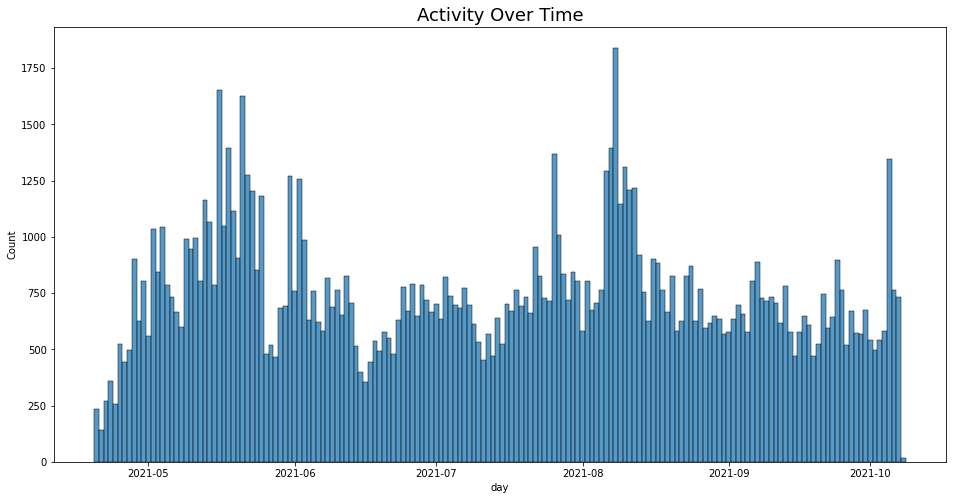

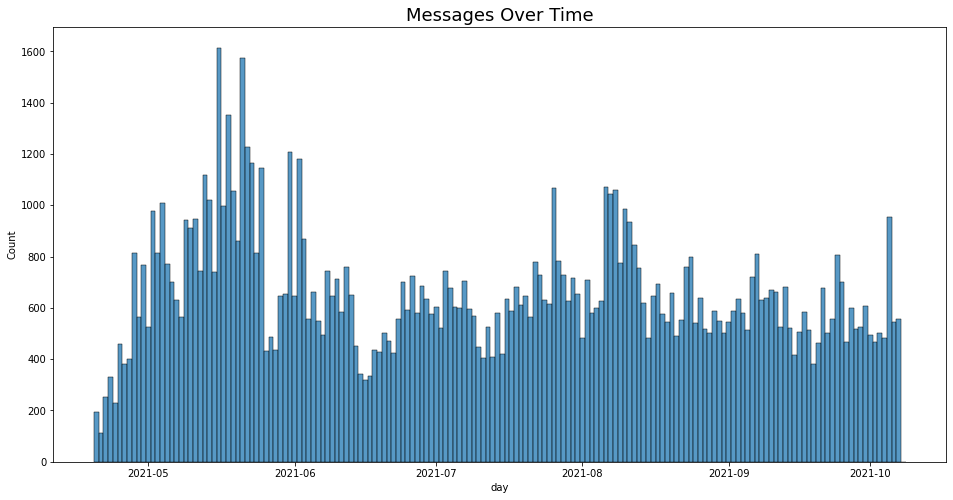

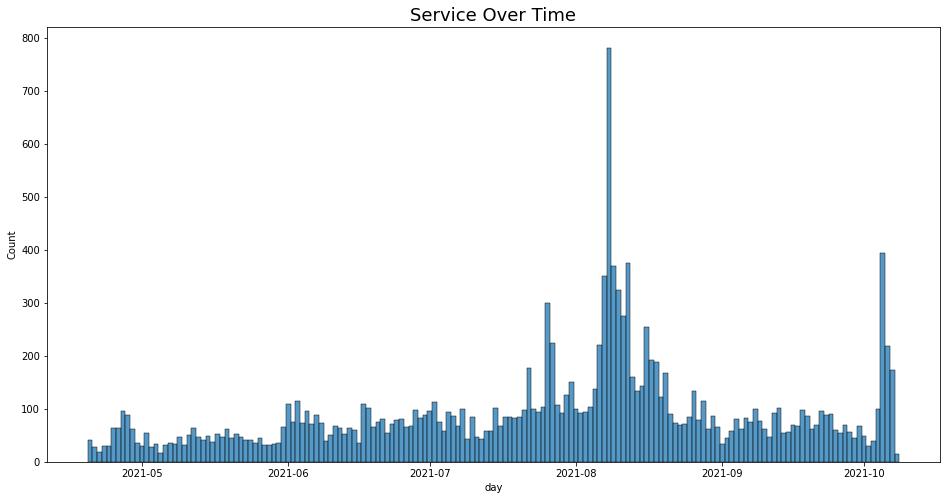

In [10]:
# Plot histplot of activity levels
fig, ax = plt.subplots(figsize = (16,8))
ax.set_title('Activity Over Time', fontsize = 18)
sns.histplot(x = 'day', data = df, bins = 169, ax = ax)
plt.show()

fig, ax = plt.subplots(figsize = (16,8))
ax.set_title('Messages Over Time', fontsize = 18)
sns.histplot(x = 'day', data = df.loc[df.type == 'message'], bins = 169, ax = ax)
plt.show()

fig, ax = plt.subplots(figsize = (16,8))
ax.set_title('Service Over Time', fontsize = 18)
sns.histplot(x = 'day', data = df.loc[df.type == 'service'], bins = 169, ax = ax)
plt.show()

Looking at the total activity level over time we observe that during mid-May, early-June, mid-August, and the start of October the chat group saw heighten levels of activties. 

Breaking the activities down to messages and services we see that all three periods saw local peaks in number of daily messages sent in the chat group while mid-August and start of October saw the highest outlying levels of services the chat group has seen till date. Since we have shown that almost all the services (15767/15854) are new members joining the chat group we can safely assume that these two peaks in services are entirely due to new members joining the group.

Looking at local news for these periods in time the following news/headlines are noteworthy:
<blockquote>
16 May - MOH announced that all Singaporean citizens, permanent residents and long-term pass holders with recent travel history to Taiwan would be required from 17 May onwards to serve a 21-day SHN (14 days at dedicated facilities, followed by 7 days at their place of residence) upon arrival. In addition, all short-term visitors would be barred from entering or transiting through Singapore.<br>
    
17 May - MOT announced that the Singapore-Hong Kong air travel bubble would once again be deferred, with a new launch date to be reviewed around 13 June.

18 May - MOH announced the authorization of the Pfizer-BioNTech COVID-19 vaccine for use on those aged 12 to 15, as well as the extension of the interval between doses from 3–4 weeks to 6–8 weeks.

2 June - MOH announced that China's CoronaVac COVID-19 vaccine would be approved for use in Singapore under the special access route, though it will not be covered under the Vaccine Injury Financial Assistance Programme.

6 August - MOH announced that from 10 August, the limit on social gatherings and visitors to households, as well as the resumption of dining-in at restaurants, would increase to 5 persons for fully-vaccinated people (while the limit remains 2 for non-vaccinated people and dining-in at hawker centres); from 19 August, up to 50% of employees currently working from home would be allowed to return to the workplace; temperature screenings at public places would also no longer be required.

9 August - National day of Singapore. By 9 August 2021, we expect that around 70% of our entire population would have completed two doses. This gives us some confidence that we can start to re-open our economy and resume more activities. However, we will continue to take a calibrated risk-based approach in re-opening. We will monitor health outcomes, particularly hospitalisation and ICU cases, to avoid exponential increases that could overwhelm our healthcare capacity.

5 October - Grandmother hospitalised after taking ivermectin to ‘protect herself’ against Covid-19.</blockquote>

In [11]:
df.iloc[5:15]

,id,type,date,actor,actor_id,action,title,text,photo,width,...,poll,saved_from,author,performer,game_message_id,score,contact_information,contact_vcard,datetime,day
5,7,service,2021-04-20T11:41:55,Dr. Mario,user142990455,invite_members,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-20 11:41:55,2021-04-20
6,8,service,2021-04-20T11:42:30,beat,user525781767,pin_message,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-20 11:42:30,2021-04-20
7,9,service,2021-04-20T11:45:14,Axl R,user1097001290,invite_members,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-20 11:45:14,2021-04-20
8,10,service,2021-04-20T11:58:44,An,user1638952737,invite_members,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-20 11:58:44,2021-04-20
9,11,message,2021-04-20T12:02:30,NaN,NaN,NaN,NaN,"[{'type': 'link', 'text': 'https://www.straits...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-20 12:02:30,2021-04-20
10,12,service,2021-04-20T12:03:46,Grace,user658123758,invite_members,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-20 12:03:46,2021-04-20
11,13,service,2021-04-20T12:04:41,beat,user525781767,edit_group_title,SG 🇸🇬 Covid Discussion,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-20 12:04:41,2021-04-20
12,14,service,2021-04-20T12:11:38,E,user1683915829,invite_members,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-20 12:11:38,2021-04-20
13,17,service,2021-04-20T12:26:11,MSN,user1049140407,invite_members,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-20 12:26:11,2021-04-20
14,19,message,2021-04-20T12:27:21,NaN,NaN,NaN,NaN,"[{'type': 'link', 'text': 'https://www.oraclef...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-20 12:27:21,2021-04-20


Looking at the dataframe we can clearly see that the index and id columns do not line up, with id of chat group activities being skipped sometimes. From personal experience working with the Telegram API, the missing ids are most likely messages that have been deleted from the chat group.

### Deleted activity over time

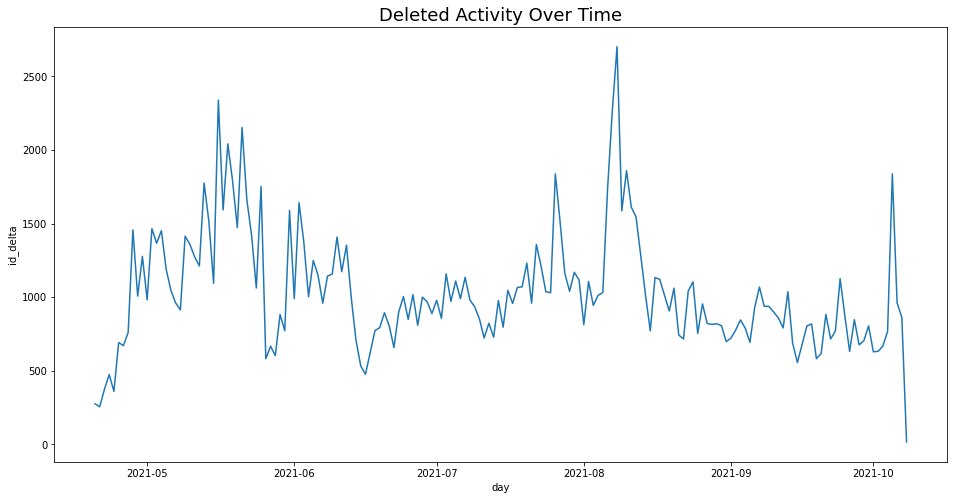

In [12]:
# Plot histplot of deleted activity

# diff in id = deleted activity
df['id_delta'] = df['id'].diff(1)

fig, ax = plt.subplots(figsize = (16,8))
ax.set_title('Deleted Activity Over Time', fontsize = 18)
sns.lineplot(x = 'day', y = 'id_delta', data = df.groupby('day').sum()['id_delta'].reset_index(), ax = ax)
plt.show()

As expected, the graph for deleted activity over time looks very similar to the histogram for activity over time, more activities sent = more activities deleted.


***

<a id = '5'></a>
## 5. Most Common Words
In this section we will be looking at texts within the messages that are sent in the group, looking at some descriptive statistics and the most common n-grams under different conditions.

In [13]:
# Separate Messages from Services
messages = df[df.type == 'message']

## Clean df
# lists to string, convert to lowercase text
messages['text_clean'] = [''.join(map(str, l)) for l in messages['text']]
messages['text_clean'] = messages['text_clean'].str.lower()

# extract emojis
def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
    
    return emoji_list

messages['emojis'] = messages.apply(lambda x: split_count(x['text_clean']), axis = 1)

# extract url to separate column
pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'
messages['url'] = messages['text_clean'].str.extract(pattern, expand = True)
                                 
# replace text url with a marker 'externalurllink'               
messages['text_clean'] = messages['text_clean'].str.replace(pattern, 'externalurllink')
messages['text_clean'] = messages['text_clean'].str.replace(r'\\n', '')
messages['text_clean'] = messages['text_clean'].str.replace(r'\\', '')

# remove @ mentions
messages['text_clean'] = messages['text_clean'].str.replace(r'@\w+', '')


# Remove stopwords and lemmatize
stop = set(stopwords.words('english'))
stop.update(['href','u200a','u200b','u200d', 'u'])
lemmatizer = WordNetLemmatizer()
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(lemmatizer.lemmatize(i.strip().lower()))
    return " ".join(final_text)

def cleantext(text):
    text = remove_stopwords(text)
    return text

messages['text_clean'] = messages['text_clean'].apply(cleantext)



# remove punctuations
messages['text_clean'] = messages['text_clean'].str.replace('[{}]'.format(string.punctuation), '')

# remove formatting for url attachments
messages[messages['text_clean'].str.contains('type')].text_clean.head() #before
messages['text_clean'] = messages['text_clean'].str.replace('type (.+?) text source', '') # remove all type + xxxxx + text strings
messages['text_clean'] = messages['text_clean'].str.replace('type (.+?) text', '') # remove all type + xxxxx + text strings
messages[messages['text_clean'].str.contains('type')].text_clean.head() #after



## Number of words in message
# word count
messages['word_length'] = messages['text_clean'].str.split().apply(len)

# if word_length = 0 and message is sticker, make text_clean the sticker emoticon
messages['text_clean'] = messages.apply(lambda x: x['sticker_emoji'] if ((x['word_length'] == 0)&(x['media_type'] == 'sticker')&(pd.notnull(x['sticker_emoji']))) else x['text_clean'], axis = 1)


# Remove characters from special keyboard, encode single emoji text as chemoji
messages['text_clean'] = messages['text_clean'].str.replace(r'[^\x00-\x7F]+', 'chemoji')
messages['text_clean'] = messages.apply(lambda x: x['text_clean'].replace('chemoji', "") if (x['word_length'] >= 1) else x['text_clean'], axis = 1)
messages['word_length'] = messages['text_clean'].str.split().apply(len)

When cleaning the texts, any urls sent were extracted to a separate column in the dataframe and replaced with a marker 'externalurllink', emojis were extracted but not replaced. Additionally, some Telegram formatting, @mentions, stopwords and punctuations were removed before the words were lemmatized.

Texts not readable were also removed(mainly Chinese characters and certain punctuations).

count    92437.000000
mean        12.142021
std         21.378752
min          0.000000
25%          2.000000
50%          7.000000
75%         14.000000
max        445.000000
Name: word_length, dtype: float64


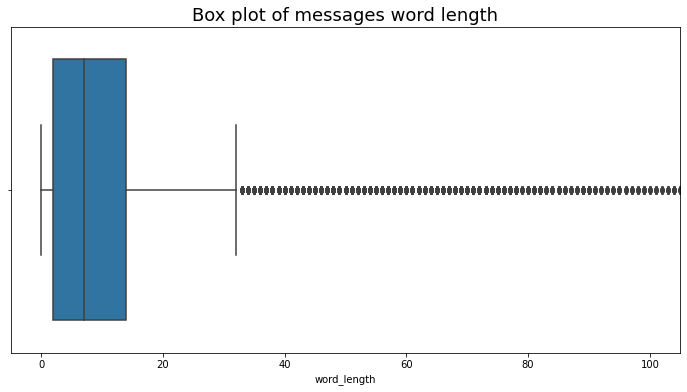

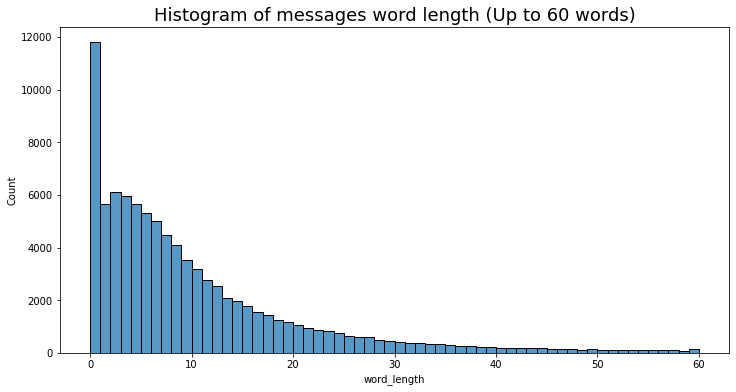

Number of messages above 60 words:  2080
Total Number of Messages (Excluding url):  92437


In [14]:
# see description of word_length
print(messages.loc[messages.url.isnull()].word_length.describe())

# Box plot
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Box plot of messages word length', fontsize = 18)
sns.boxplot(x = 'word_length', data = messages.loc[messages.url.isnull()], ax = ax)
ax.set(xlim=(-5,105))
plt.show()

# Plot number of words in messages
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Histogram of messages word length (Up to 60 words)', fontsize = 18)
sns.histplot(x = 'word_length', data = messages.loc[(messages.url.isnull()&(messages.word_length <= 60))], binwidth = 1)
plt.show()

# Number of messages above 60 words
print("Number of messages above 60 words: ", len(messages.loc[(messages.url.isnull()&(messages.word_length > 60))]))
# vs total number of messages (excluding url)
print("Total Number of Messages (Excluding url): ", len(messages.loc[(messages.url.isnull())]))

Looking at the distribution of number of words within each message, we notice that the majority of messages contains less than 10 words with approximately 97.75% of messages containing less than 60 words. The message with the highest number of words is displayed below, containing a total of 445 words.

### Longest Message

In [15]:
print("\n\n   Longest message found in chat history: \n\n")
print(messages[messages.word_length == messages[messages.url.isnull()].word_length.max()].iloc[0]['text'])



   Longest message found in chat history: 


(If anyone is still unsure of the vaccine, this should clear things up)
Thanks to the person who created this.

CDC: Hello. CDC. How can I help you?

ME: CDC, should I get the poke if I already had Covid?

CDC: “Yes, you should be poked regardless of whether you already had COVID-19. That’s because experts do not yet know how long you are protected from getting sick again after recovering from COVID-19.”

ME: Oh, okay, we don’t know how long natural immunity lasts. Got it. So, how long does poke-induced immunity last?

CDC: “There is still a lot we are learning about COVID-19 pokes and the CDC is constantly reviewing evidence and updating guidance. We don’t know how long protection lasts for those who are poked.”

ME: Okay … but wait a second. I thought you said the reason I need the poke was because we don’t know how long my natural immunity lasts, but it seems like you’re saying we ALSO don’t know how long poke immunity lasts either. So,

The longest message states "*(If anyone is still unsure of the vaccine, this should clear things up)*" before pasting a copypasta circulating around the internet show the interaction between CDC (presumably Centers for Disease Control and Prevention) and ME (presumably a person considering vaccination). The message outlines how conflicting messaging by authorities may have confused the general population about vaccines, but certain lines are clearly writtened by misconstruing what CDC has said.

### Most common words

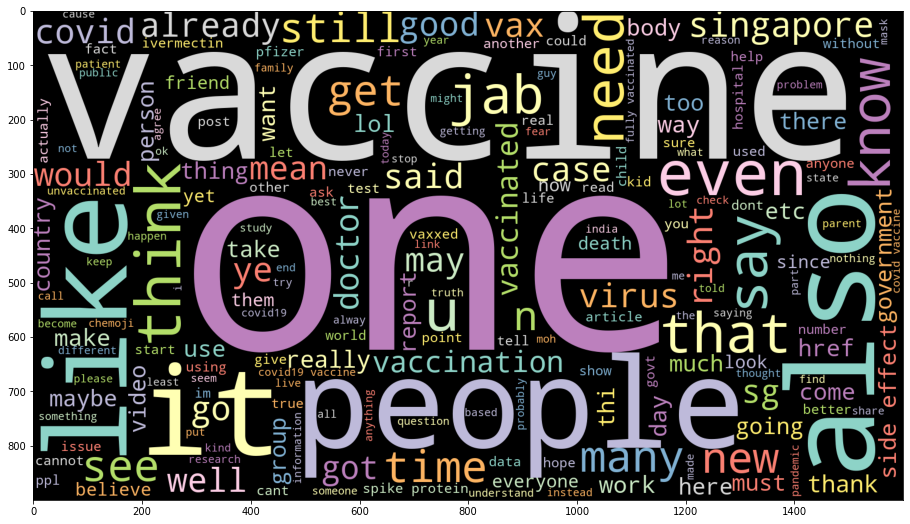

In [16]:
# Wordcloud
plt.figure(figsize = (16,9))
wc = WordCloud(max_words = 200, width = 1600, height = 900, colormap = 'Set3', stopwords = ['externalurllink']).generate(' '.join(messages.text_clean))
plt.imshow(wc)

Above is a wordcloud of all the words sent in the chatgroup.

In [17]:
# Corpus of words used in text messages
corpus = []
for i in messages.text_clean:
    for j in i.split():
        if (j.strip() != 'externalurllink')&(j.strip()!='href'): # remove markers associated with links from the corpus
            corpus.append(j.strip())

# Most common n_grams
def most_common_ngrams(corpus, n, gram):
    ngram_counts = Counter(ngrams(corpus, gram))
    return ngram_counts.most_common(n)

def convert_to_df(corpus, n, gram):
    grams = most_common_ngrams(corpus,n,gram)
    grams_df = pd.DataFrame(data = [' '.join(word) for word in [text[0] for text in grams]], columns = ['words'])
    grams_df['counts'] = [text[1] for text in grams]
    return grams_df

def plot_ngrams(corpus, n, title, df_function = convert_to_df, palette = 'crest'):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (18,6))
    fig.suptitle(str(title), fontsize = 22)
    ax1.set_title('Unigram', fontsize = 18)
    sns.barplot(y = 'words', x = 'counts', data = df_function(corpus, n, 1), ax = ax1, palette = palette)
    ax2.set_title('Bigram', fontsize = 18)
    sns.barplot(y = 'words', x = 'counts', data = df_function(corpus, n, 2), ax = ax2, palette = palette)
    ax3.set_title('Trigram', fontsize = 18)
    sns.barplot(y = 'words', x = 'counts', data = df_function(corpus, n, 3), ax = ax3, palette = palette)
    fig.tight_layout()
    plt.show()

In [18]:
### Select data within a timeframe
activity_levels = df.groupby('day').count()['id'].reset_index()

activity_levels.sort_values('id', ascending = False).head(30).sort_values('day')

,day,id
12,2021-05-02,1033
14,2021-05-04,1043
19,2021-05-09,990
20,2021-05-10,944
21,2021-05-11,997
23,2021-05-13,1165
24,2021-05-14,1064
26,2021-05-16,1652
27,2021-05-17,1050
28,2021-05-18,1397


Extracting the days with high levels of activity in the chat group we can pinpoint the active days that were seen in [Section 4](#4). We shall explore the most common n-grams within these periods of time as well.

In [19]:
def temp_corpus(start, end, messages):
    t1 = start
    t1 = datetime.datetime.strptime(t1, '%Y-%m-%d')

    t2 = end
    t2 = datetime.datetime.strptime(t2 , '%Y-%m-%d')

    df_temp = messages.loc[(messages.datetime > t1) &(messages.datetime < t2)]

    corpus_temp = []
    for i in df_temp.text_clean:
        for j in i.split():
            if (j.strip() != 'externalurllink')&(j.strip()!='href'): # remove markers associated with links from the corpus
                corpus_temp.append(j.strip())
    return corpus_temp

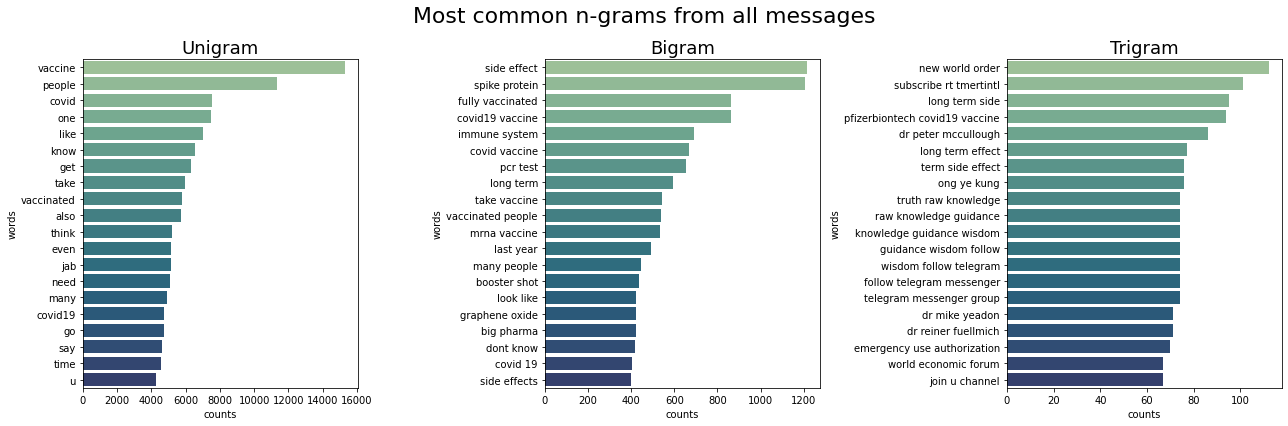

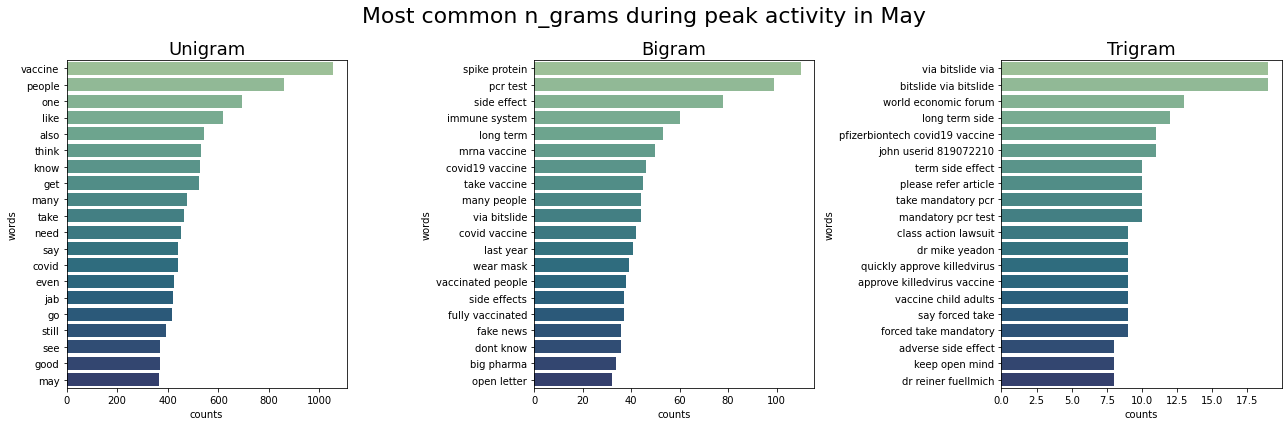

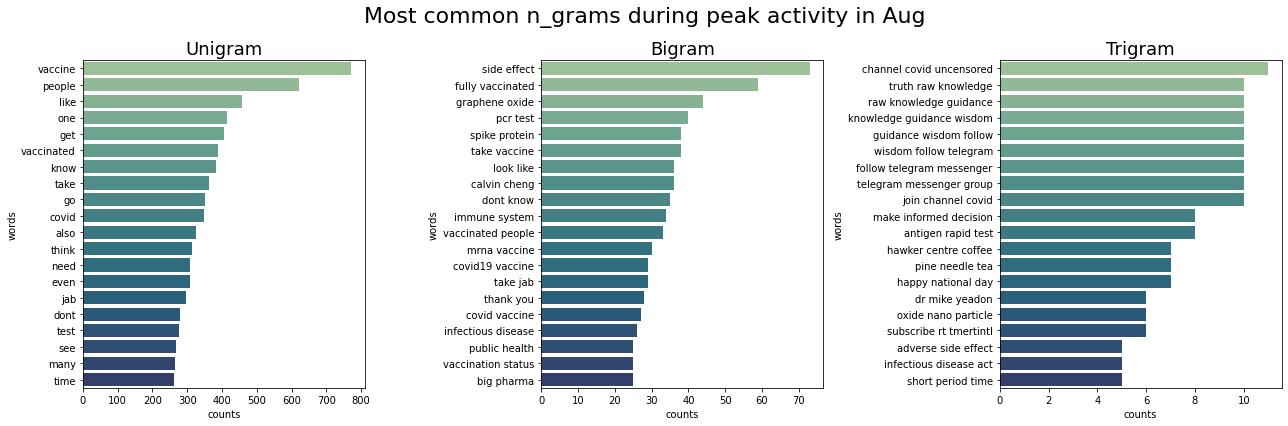

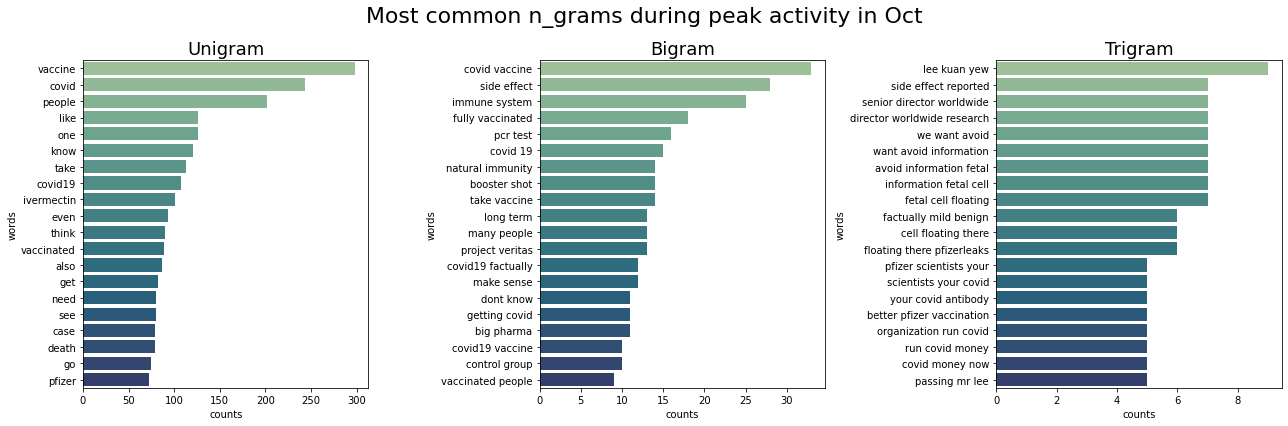

In [20]:
plot_ngrams(corpus, 20, "Most common n-grams from all messages")
plot_ngrams(temp_corpus("2021-05-13", "2021-05-23", messages), 20, "Most common n_grams during peak activity in May", palette = 'crest')
plot_ngrams(temp_corpus("2021-08-06", "2021-08-12", messages), 20, "Most common n_grams during peak activity in Aug", palette = 'crest')
plot_ngrams(temp_corpus("2021-10-05", "2021-10-08", messages), 20, "Most common n_grams during peak activity in Oct", palette = 'crest')

Looking at the most common uni/bi/tri-grams from all messages we see that most of them are related to covid and vaccines in general as expected, along with phrases such as big pharma and new world order that are popular among conspiracy theorists and anti-vaxxers in general.

When looking at the period specific n-grams we see some words/phrases that may be related to what was the hot topic in media at that point in time. For example, in early October a woman was hospitalised after self medicating using ivermection, this was reflected in the most common unigrams in that period of time where ivermectin became that 9th most commonly used word.

### Most common phrases containing specific words

In [21]:
# most common n_grams from specific words
def ngram_filter(corpus, n, gram, word = 'vaccine'):
    ngram_counts = ngrams(corpus, gram)
    
    filtered_ngrams = Counter([x for x in ngram_counts if word in x])
    grams = filtered_ngrams.most_common(n)
    grams_df = pd.DataFrame(data = [' '.join(word) for word in [text[0] for text in grams]], columns = ['words'])
    grams_df['counts'] = [text[1] for text in grams]
    return grams_df

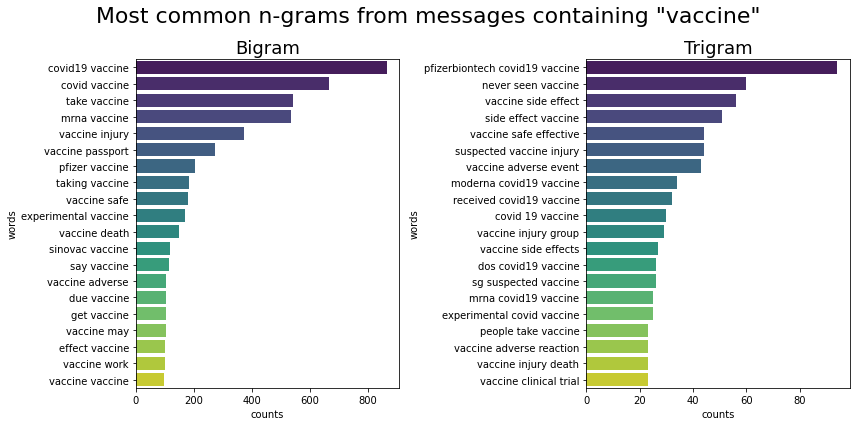

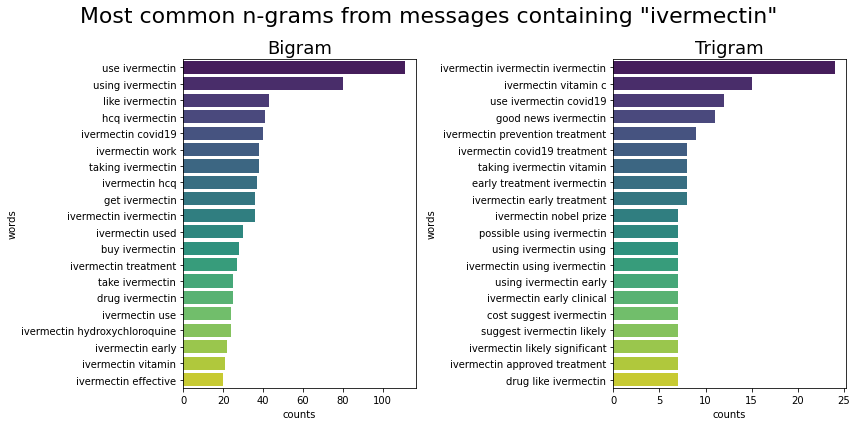

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,6))
fig.suptitle('Most common n-grams from messages containing "vaccine"', fontsize = 22)
ax1.set_title('Bigram', fontsize = 18)
sns.barplot(y = 'words', x = 'counts', data = ngram_filter(corpus, 20, 2), ax = ax1, palette = 'viridis')
ax2.set_title('Trigram', fontsize = 18)
sns.barplot(y = 'words', x = 'counts', data = ngram_filter(corpus, 20, 3), ax = ax2, palette = 'viridis')
fig.tight_layout()
plt.show()

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,6))
fig.suptitle('Most common n-grams from messages containing "ivermectin"', fontsize = 22)
ax1.set_title('Bigram', fontsize = 18)
sns.barplot(y = 'words', x = 'counts', data = ngram_filter(corpus, 20, 2,'ivermectin'), ax = ax1, palette = 'viridis')
ax2.set_title('Trigram', fontsize = 18)
sns.barplot(y = 'words', x = 'counts', data = ngram_filter(corpus, 20, 3,'ivermectin'), ax = ax2, palette = 'viridis')
fig.tight_layout()
plt.show()

When filtering for ngrams containing the most popular word "vaccine", we can infer that most discussion about the vaccines are relating to its safety and possible side efects. The most popular trigram "pfizerbiontech covid19 vaccine" suggests a lot of copy pasting from other sources as this name is typically not used in casual discussion. Most likely referencing other news articles or guidelines where this format of the name is typically used.

When filtering for ngrams containing the most popular word "ivermectin", we can infer that most discussion about the drug are related to obtaining and using it, and its effectiveness as treatment against Covid-19.

### Most shared websites

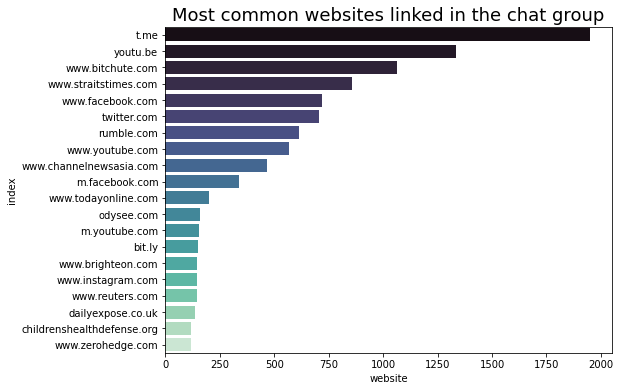

In [23]:
# Extract websites from url
websites = messages[['id','url']].dropna()
websites['website'] = websites['url'].str.split('/').str[2]
websites = websites['website'].value_counts().reset_index().head(20)


fig, ax = plt.subplots(figsize = (8,6))
ax.set_title('Most common websites linked in the chat group', fontsize = 18)
sns.barplot(x = 'website', y = 'index', data = websites, ax = ax, palette = 'mako')
plt.show()

A majority of the most common websites linked in the chat group are social media/video hosting websites. The rest are a mix of local/regional news sites and websites that have been identified to as sources of misinformation.

### Most used emojis

In [24]:
# Find Most common emojis
corpus_emoji = []
for i in messages.emojis:
    for j in i:
        corpus_emoji.append(j.strip())
emoji_count = Counter(corpus_emoji)
emoji_count.most_common(20)

[('😂', 3235),
 ('🤣', 2104),
 ('👍', 1719),
 ('🙏', 1189),
 ('💉', 826),
 ('🤔', 744),
 ('😅', 669),
 ('👏', 557),
 ('😐', 498),
 ('😊', 465),
 ('🙄', 460),
 ('👇', 445),
 ('😱', 433),
 ('❤️', 402),
 ('☺️', 384),
 ('😔', 371),
 ('👍🏻', 357),
 ('😁', 349),
 ('😆', 347),
 ('🚨', 347)]

Above is the most commonly used emojis and how many times they were used in the chat group, with the laughing emojis used the most.

***

<a id = '6'></a>
## 6. Most Active Users
In this section we will look at the number of messages sent by each user and find the most active users in the chat group.

count    2864.000000
mean       39.283520
std       157.831856
min         1.000000
25%         1.000000
50%         4.000000
75%        17.000000
max      3243.000000
Name: from_id, dtype: float64


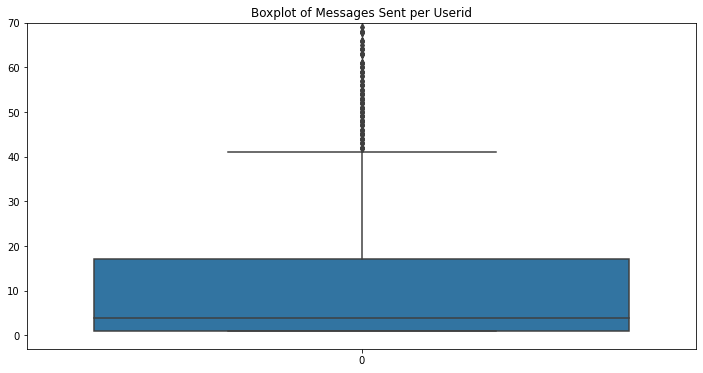

In [25]:
# Most Messages
print(df.from_id.value_counts().describe())

fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Boxplot of Messages Sent per Userid')
sns.boxplot(data = df.from_id.value_counts(), ax = ax)
ax.set(ylim = (-3, 70))
plt.show()


On average users in the chatgroup has sent less than 5 messages, with the vast majority having sent less than 40 messages. This does not take into account users who have never sent a message in the chat.

In [26]:
# Most Messages
print("Users with the most messages sent:")
print(df.from_id.value_counts()[:10])

# Most Service actions
print("\nUsers with the most service actions:")
print(df.actor_id.value_counts()[:10])

Users with the most messages sent:
channel1230879115    3243
user1369998609       2935
user1396312263       1953
user345138757        1940
user1351390820       1895
user1068497698       1675
user1453303339       1524
user1523094571       1493
user1539690656       1471
user838180373        1385
Name: from_id, dtype: int64

Users with the most service actions:
user1198022213       224
user1846404430       138
user1079340259       112
user864525687         93
user1330922999        61
channel1230879115     56
user1225734187        53
user1940402948        51
user1428165432        49
user1232987741        48
Name: actor_id, dtype: int64


In [27]:
# Any overlaps?
most_message = df.from_id.value_counts()[:10].reset_index()
most_system = df.actor_id.value_counts()[:10].reset_index()
print(most_message[most_message['index'].isin(most_system['index'])]['index'].values)

['channel1230879115']


In [28]:
df.iloc[0][['id','type','date','actor','actor_id','action','title']]

id                            1
type                    service
date        2021-04-20T11:27:38
actor       SG 🇸🇬 Covid La Kopi
actor_id      channel1230879115
action       migrate_from_group
title       SG Covid Discussion
Name: 0, dtype: object

When we compare the users with the most messages sent and the most service actions we find that only "channel1230879115" is present in both. Incidentally this user is the creator/admin of the chat group.

### Number of messages sent per user

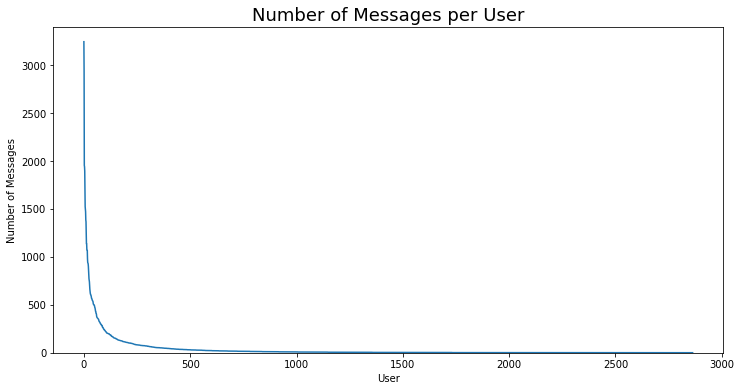

Number of users to have sent a message in the chat history:  2864
Users who has sent 101 messages :
                index  from_id
215   user156998005      101
216  user1324163177      101
217  user1683528420      101
218    user26529311      101
219   user402836458      101
220  user1217016403      101


Number of messages:  112508
Number of messages from most active users(above 100 msg):  83475
Percentage of all messages sent: 74.19%


In [29]:
# plot number of messages
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Number of Messages per User', fontsize = 18)
sns.lineplot(x = np.arange(len(df.from_id.value_counts().reset_index())), y = 'from_id', data = df.from_id.value_counts().reset_index(), ax = ax)
ax.set(ylim = (0,3400))
ax.set(xlabel = 'User')
ax.set(ylabel = 'Number of Messages')
plt.show()

print("Number of users to have sent a message in the chat history: ",len(df.from_id.value_counts().reset_index()))
print("Users who has sent 101 messages :\n ", df.from_id.value_counts().reset_index().loc[df.from_id.value_counts().reset_index().from_id == 101]) # 220 users with at least 100 messages

print("\n\nNumber of messages: ", len(messages))
print("Number of messages from most active users(above 100 msg): ",df.from_id.value_counts().reset_index().iloc[:221].sum()['from_id']) # more than 70% of all messages come from less than 10% of users
print("Percentage of all messages sent: {}%".format(round(df.from_id.value_counts().reset_index().iloc[:221].sum()['from_id']/len(messages) * 100, 2)))

2864 users have sent a message in the chat group. Out of these 2864 users 220 users have sent a total more than 100 messages. Just these 220 users have sent 74% of all messages ever sent in the chat group.

### Replies to users

In [30]:
# Most replied to users
def find_reply_user(df, x):
    if x['reply_to_message_id'] > 0:
        userid = df.loc[df['id'] == x['reply_to_message_id']]['from_id']
        if len(userid) == 0:
            return -1
        else:
            return userid.values[0]
    else:
        return np.nan
        
# Create new feature to track userid the message sender is replying to        
df['reply_to_user'] = df.apply(lambda x: find_reply_user(df, x), axis = 1)

df.reply_to_user.value_counts()[:10] # Vast majority of messages replied to are deleted.

-1                   16449
user1369998609        1269
user345138757          738
user838180373          721
user1351390820         698
user1453303339         684
user1396312263         651
channel1230879115      639
user1573374561         627
user1906255281         562
Name: reply_to_user, dtype: int64

When looking at the users that received the most replies, we observe that 16449 messages that were replied to were deleted.

### Overlaps?

In [31]:
# Overlap between most messages and most replied to
most_replied = df.reply_to_user.value_counts()[:10].reset_index()
print(most_message[most_message['index'].isin(most_replied['index'])]['index']) # 7 out of 10 top ten replied to users are in top 10 users with most messages 

0    channel1230879115
1       user1369998609
2       user1396312263
3        user345138757
4       user1351390820
6       user1453303339
9        user838180373
Name: index, dtype: object


Checking the userid between the users with most messages and the users who received the most replies we see that 7 out of 10 users are present in both.

### Linguistic diversity

In [32]:
# Check proportion of Users' corpus that are unique words
def user_corpus(userid, messages):
    corpus = []
    for i in messages.loc[(messages.from_id == str(userid))]['text_clean']:
        for j in i.split():
            if (j.strip() != 'externalurllink')&(j.strip()!='href'): # remove markers associated with links from the corpus
                corpus.append(j.strip())
    return corpus

def unique_words(corpus):
    return (round(len(set(corpus)) / len(corpus),4))

user_scores = pd.DataFrame()
user_scores['users'] = most_message['index']
user_scores['scores'] = user_scores.apply(lambda x: unique_words(user_corpus(x['users'], messages)), axis = 1)

user_scores

,users,scores
0,channel1230879115,0.1803
1,user1369998609,0.1762
2,user1396312263,0.2816
3,user345138757,0.2677
4,user1351390820,0.2311
5,user1068497698,0.2826
6,user1453303339,0.2132
7,user1523094571,0.2784
8,user1539690656,0.2819
9,user838180373,0.1490


If interested in more in-depth text analysis of the chat group, the linguistic diversity is a simple way to measure how varied the vocabulary of a user is. From the above we can see that "user1068497698" has the most varied vocabulary with a score of 0.2826 while "user838180373" has the most limited vocabulary with a score of 0.1490.

### Most active user's most common words/phrases

In [33]:
user0_corpus = user_corpus('channel1230879115', messages)

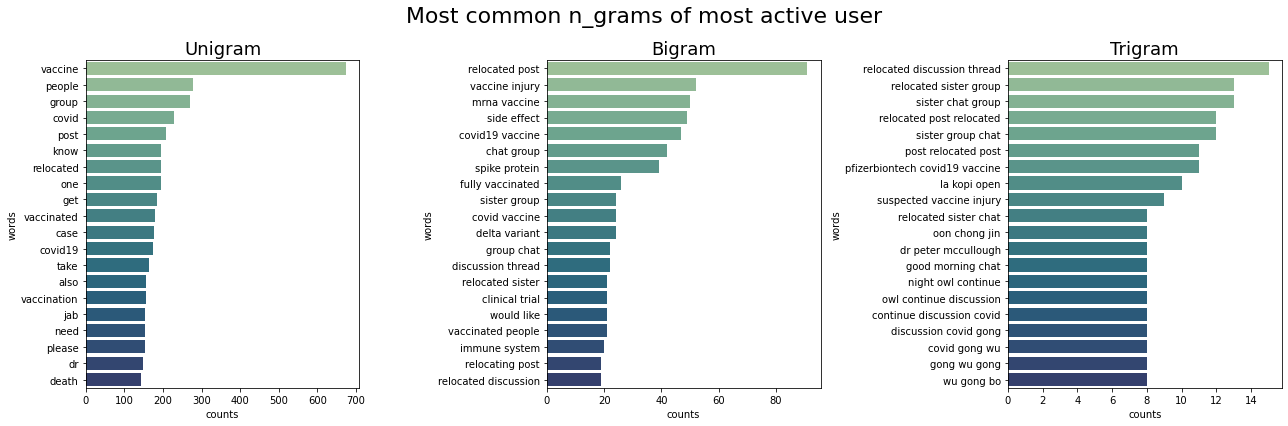

In [34]:
plot_ngrams(user0_corpus, 20, "Most common n_grams of most active user", palette = 'crest')

Looking at the corpus of the most active user we see that it's mostly similar to the common n-grams found in the chat group, with the exception of trigrams where phrases related to administration of the chat group are present.

In [35]:
user9_corpus = user_corpus('user838180373', messages)       

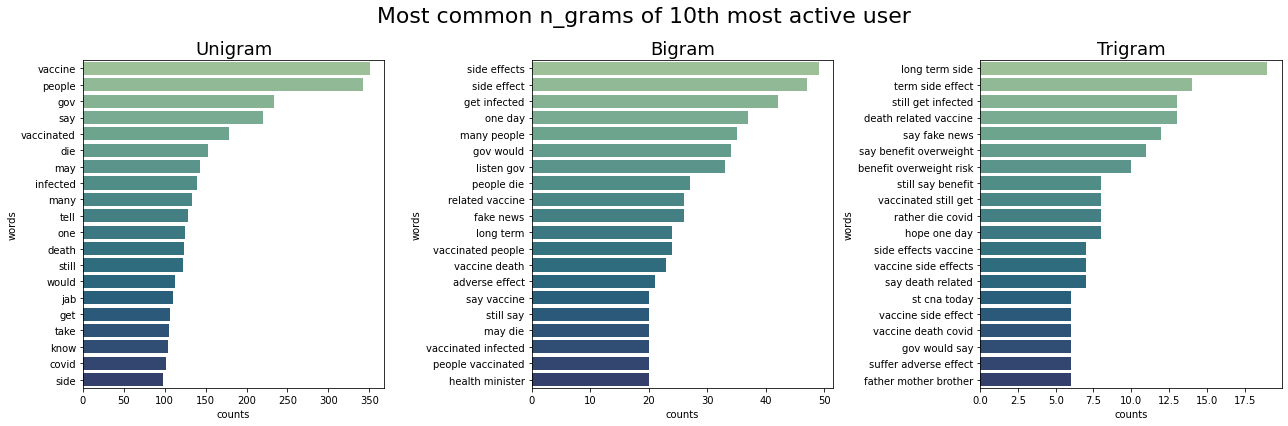

In [36]:
plot_ngrams(user9_corpus, 20, "Most common n_grams of 10th most active user", palette = 'crest')

Looking at the corpus of the 10th most active user we see that once again it's mostly similar to the common n-grams found in the chat group, with slightly more obvious anti-vax sentiments present such as "vaccinated still get" and "rather die covid".

### Users' interactions

In [37]:
# Top users interactions
def replies_list(userid, df, most_message):
    user_replies = df.loc[(df['reply_to_user'].notnull())*(df['from_id'] == str(userid))]
    return user_replies

def replies_score(userid, df, most_message):
    top_users = most_message['index'].values
    user_replies_score = len(replies_list(userid, df, most_message).loc[replies_list(userid, df, most_message)['reply_to_user'].isin(top_users)])/len(replies_list(userid, df, most_message))
    return user_replies_score

def replies(userid, df):
    user_replies = df.loc[(df['reply_to_user'].notnull())*(df['from_id'] == str(userid))]
    user_messages = df.loc[(df['from_id'] == str(userid))]
    return len(user_replies)/len(user_messages)

# 220 Users have sent more than 100 messages to the groupchat
most_message_220 = df.from_id.value_counts()[:220].reset_index()
replies_to_220 = []
for userid in most_message_220['index'].values[:10]:
    print('{} replies to messages {}% of the time.'.format(str(userid), round(replies(userid, df),2)))
    print('{} replies to the {} most active members {}% of the time.\n'.format(str(userid), len(most_message_220['index'].values), round(replies_score(str(userid), df, most_message_220)*100, 2)))
    replies_to_220.append(replies_score(str(userid), df, most_message_220)*100)

print("The top 10 users replies to the top 220 users {}% of the time".format(round(np.mean(replies_to_220),2)))

channel1230879115 replies to messages 0.24% of the time.
channel1230879115 replies to the 220 most active members 44.67% of the time.

user1369998609 replies to messages 0.95% of the time.
user1369998609 replies to the 220 most active members 57.75% of the time.

user1396312263 replies to messages 0.69% of the time.
user1396312263 replies to the 220 most active members 60.33% of the time.

user345138757 replies to messages 0.71% of the time.
user345138757 replies to the 220 most active members 43.4% of the time.

user1351390820 replies to messages 0.75% of the time.
user1351390820 replies to the 220 most active members 57.39% of the time.

user1068497698 replies to messages 0.45% of the time.
user1068497698 replies to the 220 most active members 56.89% of the time.

user1453303339 replies to messages 0.86% of the time.
user1453303339 replies to the 220 most active members 59.04% of the time.

user1523094571 replies to messages 0.34% of the time.
user1523094571 replies to the 220 most a

When looking at how often the top 10 user replies to messages and how often were the replies target at the top 220 users, we can infer that they are more likely to users outside the top 220. 

The top 220 users are users who sent more than 100 messages, making up 74% of all the messages in the chat group, which means that around half of the replies from the top 10 users are directed to the remaining 26% messages.

***
<a id = '7'></a>
## 7. Most Replied To Messages

In [38]:
### Most replied to messages
most_replied = messages.reply_to_message_id.value_counts().iloc[:20].reset_index()
most_replied.columns = ['id','reply_counts']

most_replied_messages = messages.loc[messages.id.isin(most_replied['id'])].merge(most_replied, on = 'id')
most_replied_messages[['id','text']]

print("\n\nNumber of undeleted messages from the Top 20 most replied to messages : ", len(most_replied_messages))
print("\nDataframe of available Top 20 most replied to messages:")
most_replied_messages[['id','text','from_id','reply_counts']]



Number of undeleted messages from the Top 20 most replied to messages :  16

Dataframe of available Top 20 most replied to messages:


,id,text,from_id,reply_counts
0,36342,Hi. I like to address something concerning. \n...,user774588086,20
1,38121,"[For vaccine injury submission and discussion,...",channel1458709914,41
2,38123,"For international topic discussions, please go...",channel1458709914,36
3,38125,"For vaccine related topics, please go to our d...",channel1458709914,28
4,38128,"[For local topic discussions, please go to dis...",channel1458709914,54
5,38134,[Contribute your meme and joke ideas here!\n\n...,channel1458709914,184
6,40503,For Chinese Covid-related posts\n有关新冠病毒资料,channel1458709914,175
7,92799,I found out today that I'm the only one unvacc...,user95683785,18
8,105413,My group plans on starting legal proceedings i...,user1400017332,14
9,119032,Just to inform everyone that I have made a pol...,user445886510,26


If we look at the top 20 messages that received the most replies we observe that 4 of these messages have been deleted, while 6 of these messages are administrative messages and should be removed.

In [39]:
# Remove administrative messages
most_replied = most_replied.loc[~most_replied['id'].isin([float(38121), float(38123), float(38125), float(38128), float(38134), float(40503)])]
                                
print("\nNumber of valid messages from the Top 20 most replied to messages: ", most_replied['id'].isin(most_replied_messages['id']).sum()) # find undeleted messages

print("\nDataframe of valid messages:")
most_replied_messages.loc[most_replied_messages['id'].isin(most_replied['id'])][['id','text','reply_counts']]


Number of valid messages from the Top 20 most replied to messages:  10

Dataframe of valid messages:


,id,text,reply_counts
0,36342,Hi. I like to address something concerning. \n...,20
7,92799,I found out today that I'm the only one unvacc...,18
8,105413,My group plans on starting legal proceedings i...,14
9,119032,Just to inform everyone that I have made a pol...,26
10,124619,Hi My daughter is 20 just graduated and bond u...,16
11,127072,"[Fyi all.. , {'type': 'link', 'text': 'https:/...",24
12,128387,"Hi all, my sis doc advise her to get vax becau...",14
13,138206,My open letter to Ong YK\nDear sir\nAt 18 year...,16
14,138297,I wrote this on Ong Ye Kung’s FB. No doubt it ...,21
15,165466,These experts now admit their mistakes with a ...,16


### Sample message from the top 10 most-replied-to message

In [40]:
# Sample text
print("\n Chosen sample text:")
print(most_replied_messages.loc[most_replied_messages['id'] == float(128387)].iloc[0]['text'])

print("\n\n Texts replying to sample text:")
message_sample = messages.loc[messages.reply_to_message_id == float(128387)]
message_sample[['id','text']]


 Chosen sample text:
Hi all, my sis doc advise her to get vax because she is pregnant. And said it’s safe after 15weeks. What is your take


 Texts replying to sample text:


,id,text
89300,128391,NEVER TAKE THIS. there are many miscarriages c...
89301,128392,Ask doc to undertake for the rest of his/her l...
89302,128393,Who is the doctor?
89307,128399,Maybe your sister can ask her doctor to write ...
89316,128410,
89322,128417,Remember thalidomide? Drs said it was safe but...
89328,128426,The vaccine had been administered in Eu countr...
89330,128428,Ask doctor write meno anything happen sue the ...
89332,128430,Remember that this 💉is only experimental. Don’...
89338,128437,Pregnant women are advised not to take caffein...


### Replies to the sample message

In [41]:
for i in range(len(message_sample)):
    print("\n Reply Number ", i+1)
    print(message_sample['text'].iloc[i])


 Reply Number  1
NEVER TAKE THIS. there are many miscarriages cases.

 Reply Number  2
Ask doc to undertake for the rest of his/her life if any issues the baby might have from the jab

 Reply Number  3
Who is the doctor?

 Reply Number  4
Maybe your sister can ask her doctor to write it down on a paper sheet and sign it — stating there will be no problems — if he is so sure.

 Reply Number  5


 Reply Number  6
Remember thalidomide? Drs said it was safe but yet babies born to mothers who took it were severely disabled. Do you trust the drs? Nursing baby of a vaccinated mum died.

 Reply Number  7
The vaccine had been administered in Eu countries and Usa earlier even for pregnant women stated as safe.

But how long the vaccine has introduced?  Is there anybody whose pregnant on first month or first trimester till the delivery to say this is really safe to pregnant and unborn child?

Reported of miscarriages seen.
So the clinical trial for this is not absolutely safe at all if the vacci

There are many issue with the replies to the sample message but in this notebook we shall look at their claims/concerns regarding vaccines causing miscarriages. 

### Misinformation/Disinformation
A cursory search in the chat group shows mostly unfounded miscarriage claims, a common number seen was 80% chance of miscarriages due to vaccines and a quoted reference being the study [Preliminary Findings of mRNA Covid-19 Vaccine Safety in Pregnant Persons](https://www.nejm.org/doi/full/10.1056/nejmoa2104983).

Upon further investigations of the claims of miscarriages the follow quote was found
<blockquote>However, when reading the small print of table 4, in which they claim just 104 / 12.6% of 827 completed pregnancies resulted in miscarriage (spontaneous abortion), we can see that the numbers they have presented are extremely misleading.<br><br>
This is because of the 827 completed pregnancies, 700 / 86% of the women had received a dose of either the Pfizer or Moderna Covid-19 vaccine during the third trimester of pregnancy. The third trimester of pregnancy is from week 27 – 40, and it is therefore impossible to suffer a miscarriage due to the fact they are considered as occurring prior to week 20 of a pregnancy.<br><br>
This means just 127 women received either the Pfizer or Moderna Covid-19 vaccine during the first / second trimester, with 104 of the woman sadly losing their baby.<br><br>
Therefore the rate of incidence of miscarriage is 82%, not 12.6% as presented in the findings of the study.<br><br>
It is impossible for anyone vaccinated during the third trimester to suffer a miscarriage in respect of the parameters set in the study. A pregnancy loss in this case would be considered a still birth, occurring after week 20 of pregnancy.
The authors of this study have manipulated the data to show that the Covid-19 vaccines are safe for use during pregnancy. <br><br>The actual findings show that they are far from it. Their actions are now having dire consequences for women throughout the United Kingdom.</blockquote>

From the small print of the **same table** we can find the following point
<blockquote>A total of 96 of 104 spontaneous abortions (92.3%) occurred before 13 weeks of gestation. No denominator was available to calculate a risk estimate for spontaneous abortions, because at the time of this report, follow-up through 20 weeks was not yet available for 905 of the 1224 participants vaccinated within 30 days before the first day of the last menstrual period or in the first trimester. Furthermore, any risk estimate would need to account for gestational week–specific risk of spontaneous abortion.</blockquote>

This point explains that no conclusion should be drawn from this part of the study yet as the data has not yet been collected, in particular the study is waiting for data for 905 of the 1224 participants who fit into this category. In the paper from the paragraph before Table 4 we find
<blockquote>Receipt of a first dose of vaccine meeting registry-eligibility criteria was reported by 92 participants (2.3%) during the periconception period, by 1132 (28.6%) in the first trimester of pregnancy,</blockquote>

which adds up to the 1224 participants that fit into this category. Simply put, out of 1224 participants 96(104) had a spontaneous abortion <13wk(<20wk) after receiving the vaccine during the periconception period or in the first trimester of pregnancy at that point of the study.

### Figures still show miscarriages after vaccinations
From these figures one may ask; this means that $\frac{104}{1224} = 0.0849 = 8.49\%$ of participants vaccinated during the first trimester and before had a miscarriage? Meaning almost 1 in 12 pregnancies will lead to miscarriages if vaccinated? If looking at these figures at a face value, the answer is yes.

However, this conclusion ignores the baseline population miscarriage rates which is approximately 10%-20%, with a majority of miscarriages occuring in the first trimester. This makes the 8.49% of the participants lower than the population miscarriage rate. Does this mean that vaccinations reduce miscarriages rate? *No. It has to be stressed that the data is not yet complete enough for conclusions to be drawn.*

### Takeaway
A very common phrase heard nowadays is "*I've done my research*", an inquisitive mind and a drive to learn is a commendable trait. However, problems arise when people believe their research holds the same weight as scientific research.

Very similar to a layperson's understanding of the word "Theory" vs the scientific use of "Theory", theory to a layperson usually means something closer to an unproven hypothesis whereas scientific theories are generally considered as facts. In this case research for a layperson usually refers to using a search engine to find articles or social media posts that aligns with their perspectives whereas scientific research typical employs a rigorous scientific method to collect evidence to disprove or support their hypotheses, this is before factoring in the years an expert has spent building up fundamentals for their specific field.

Information is widely available, but it doesn't mean we have the background knowledge to understand it. Evident from the miscarriage example found in this chat group, most people lack even the basic ability to understand the setup of an experiment much less understand the data gathered from it.

***

<a id = '8'></a>
## 8. Final Words
In this notebook we have explored and analysed chat history data from a Telegram chat group and the messages I read while looking at the data is concerning.

At the time of writing, the sheer scale and volume of data supporting the effectiveness of covid vaccines eclipses that for ivermectin or any other alternative medicine. If the data available in favor of these vaccines is insufficient for anyone to accept their use then the same conclusions should naturally be drawn for alternative medicine. This expands to many other conspiracies most notably the flat Earth "theory" and 5g/microchips conspiracy, many of which are far more easily disproven by a layperson than matters regarding vaccines.